# Semantic Segmentation Using U-Net
<font color='cyan'> Responsible TA: Amirhossein Razlighi, Reza Vahidimajd </font>

In this excercise, you will design and train a CNN-based network called U-Net. This type of networks are used for semantic segmentation. This task is, as it's called, segmenting the image, semantically to different parts. You can consider this as a classification, done on each pixel of the image! Below, you can see an example of the task:


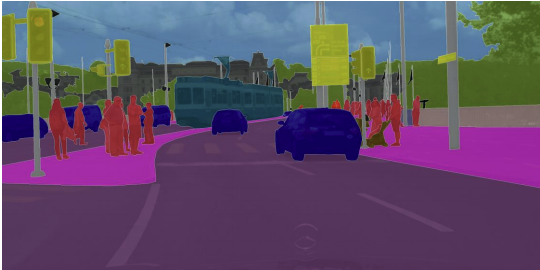 <br>
Example of a segmented image <br>


We will use a dataset called "CARLA" for this excercise. This dataset is used for "Self-Driving Car" Purposes. As you may know, understanding each pixel (in the view point of car) is an important task for self-driving cars. Let's proceed with this task to the end of this excercise!

## Downloading Dataset

In [ ]:
%pip install --upgrade --no-cache-dir gdown

In [1]:
!gdown --id 11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3
From (redirected): https://drive.google.com/uc?id=11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3&confirm=t&uuid=efb65175-65de-485a-94e5-570d3f7cf14f
To: /content/Files.zip
100% 545M/545M [00:07<00:00, 68.6MB/s]


In [2]:
!unzip Files.zip

Archive:  Files.zip
  inflating: Files/data/CameraRGB/002128.png  
  inflating: Files/data/CameraRGB/008579.png  
  inflating: Files/data/CameraRGB/015232.png  
  inflating: Files/data/CameraRGB/006878.png  
  inflating: Files/data/CameraRGB/008104.png  
  inflating: Files/data/CameraRGB/002281.png  
  inflating: Files/data/CameraRGB/004063.png  
  inflating: Files/data/CameraRGB/049745.png  
  inflating: Files/data/CameraRGB/013414.png  
  inflating: Files/data/CameraRGB/011470.png  
  inflating: Files/data/CameraRGB/022243.png  
  inflating: Files/data/CameraRGB/049187.png  
  inflating: Files/data/CameraRGB/011056.png  
  inflating: Files/data/CameraRGB/049727.png  
  inflating: Files/data/CameraRGB/006896.png  
  inflating: Files/data/CameraRGB/012028.png  
  inflating: Files/data/CameraRGB/009569.png  
  inflating: Files/data/CameraRGB/007787.png  
  inflating: Files/data/CameraRGB/010561.png  
  inflating: Files/data/CameraRGB/064397.png  
  inflating: Files/data/CameraRGB/015016

In [ ]:
%pip install --upgrade torch torchvision torchsummary

     ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/779.1 MB 69.3 MB/s eta 0:00:11
ERROR: Operation cancelled by user


<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

### Set torch device to appropriate type for GPU training

In [2]:
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
)
device

device(type='mps')

<a name='2'></a>
## 2 - Load the Data

In [3]:
path = "../"
image_path = os.path.join(path, "Files/data/CameraRGB/")
mask_path = os.path.join(path, "Files/data/CameraMask/")
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=2`. Otherwise the autograder will throw a `list index out of range` error.

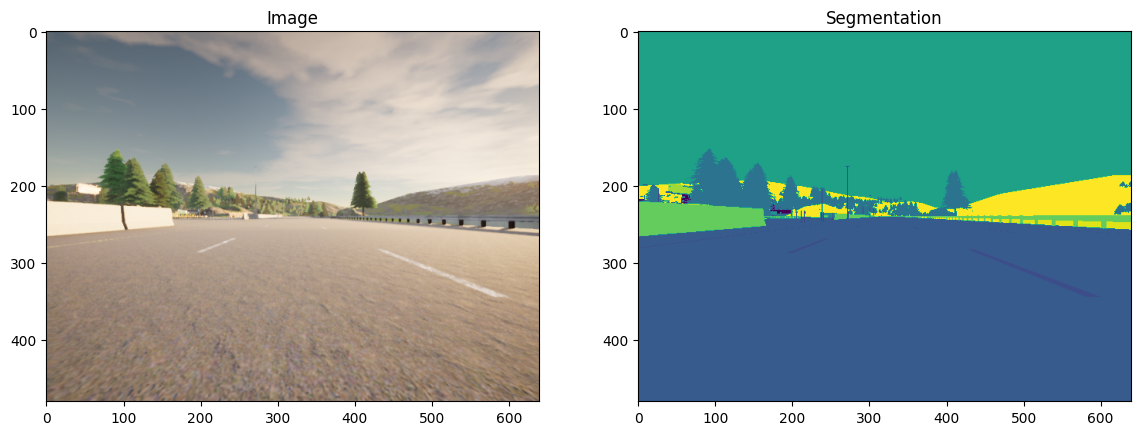

In [4]:
N = 5
img = imageio.v2.imread(image_list[N])
mask = imageio.v2.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')
plt.show()

<a name='2-2'></a>
### 2.2 - Preprocess Your Data



In [5]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory, MasksDirectory):
        self.ImagesDirectory = ImagesDirectory
        self.MasksDirectory = MasksDirectory
        self.images = os.listdir(self.ImagesDirectory)
        self.masks = os.listdir(self.MasksDirectory)
        self.mask_transforms = transforms.Compose(
            [
                transforms.Resize(
                    (192, 256), interpolation=transforms.InterpolationMode.NEAREST
                )
            ]
        )
        self.image_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(
                    (192, 256), interpolation=transforms.InterpolationMode.NEAREST
                ),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x[0:3]),
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]

        img_path = os.path.join(self.ImagesDirectory, img_name)
        img = io.read_file(img_path)
        img = io.decode_png(img)

        mask_path = os.path.join(self.MasksDirectory, img_name)
        mask = io.read_image(mask_path)
        mask, _ = torch.max(mask[0:3], dim=0, keepdim=True)
        img, mask = self.image_transforms(img), self.mask_transforms(mask)
        return {"IMAGE": img, "MASK": mask}

<a name='2-3'></a>
### 2.3 - Hyper-parameters and Optimizer

In [6]:
# TO DO
EPOCHS = 15
BATCH_SIZE = 16
LR = 10 ** -4
B1 = 0.9
B2 = 0.999

<a name='3'></a>
## 3 - U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

You will see the transpose convolution referred to by several names, including "deconvolution" and "upconvolution", but these are all the same thing. You will also see the model's architecture in the following cells.

<a name='3-1'></a>
### 3.1 - Model Details

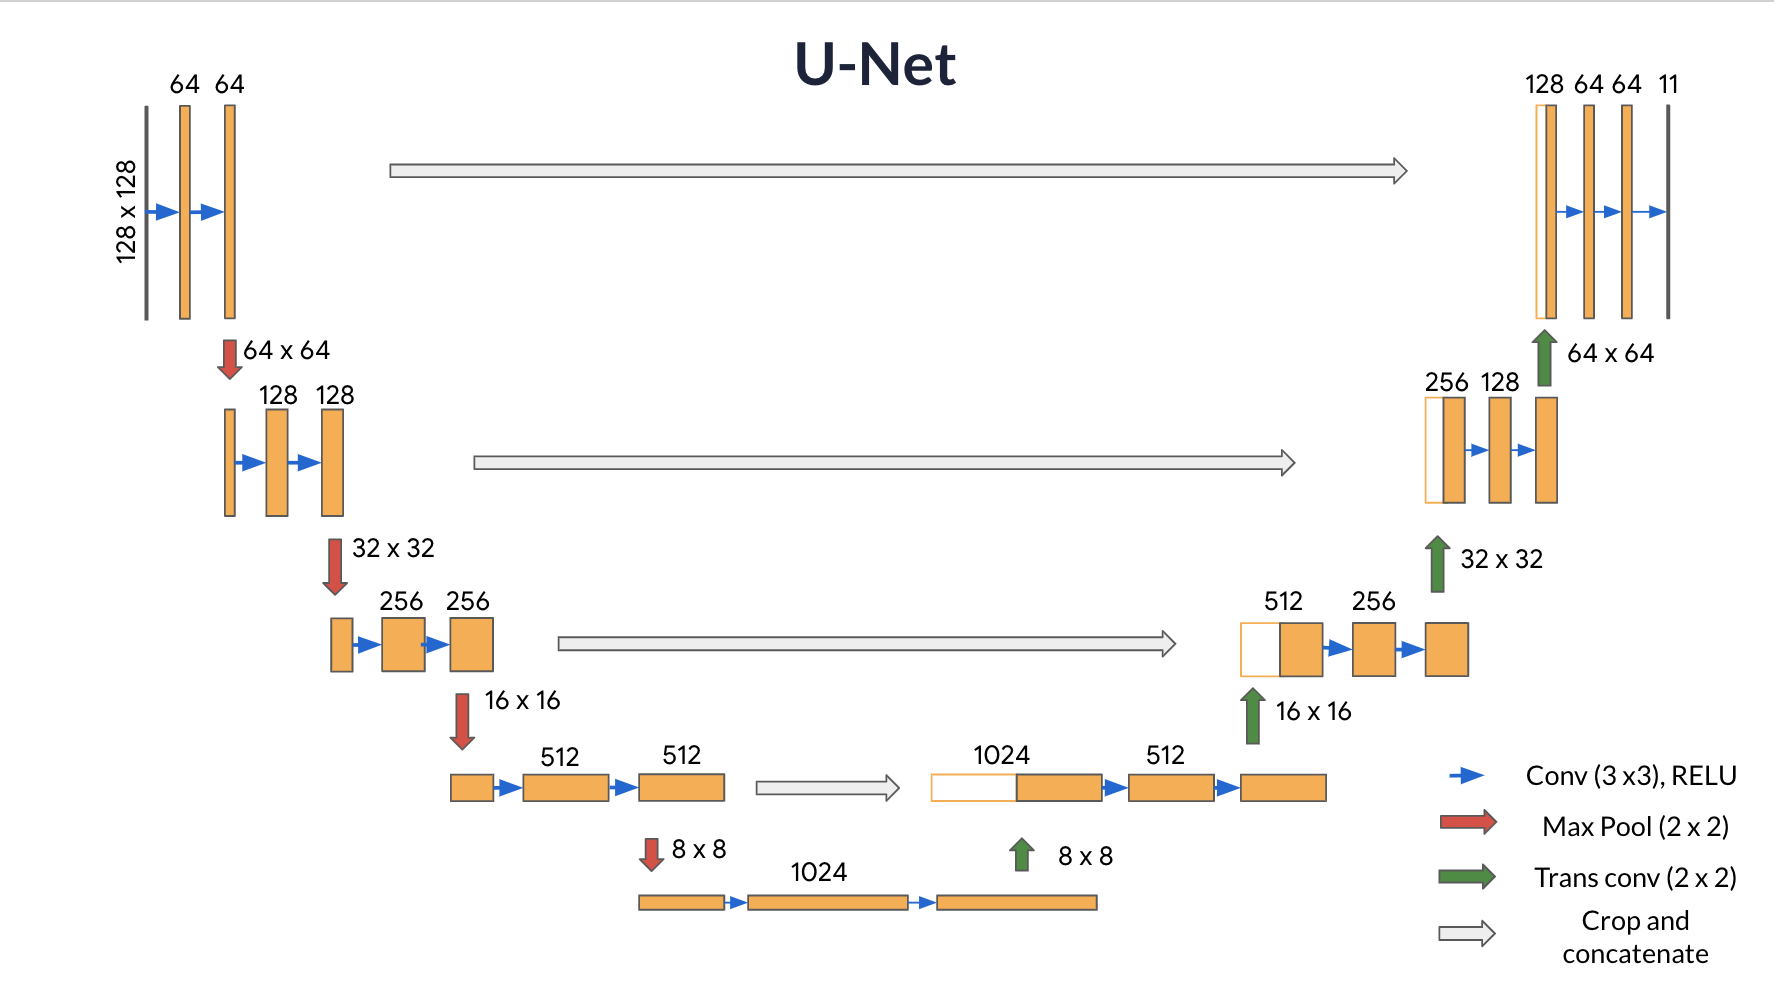<br>
U-Net Architecture<br>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 valid padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.

**Important Note:**
The figures shown in the assignment for the U-Net architecture depict the layer dimensions and filter sizes as per the original paper on U-Net with smaller images. However, due to computational constraints for this assignment, you will code only half of those filters. The purpose of showing you the original dimensions is to give you the flavour of the original U-Net architecture. The important takeaway is that you multiply by 2 the number of filters used in the previous step. The notebook includes all of the necessary instructions and hints to help you code the U-Net architecture needed for this assignment.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block)

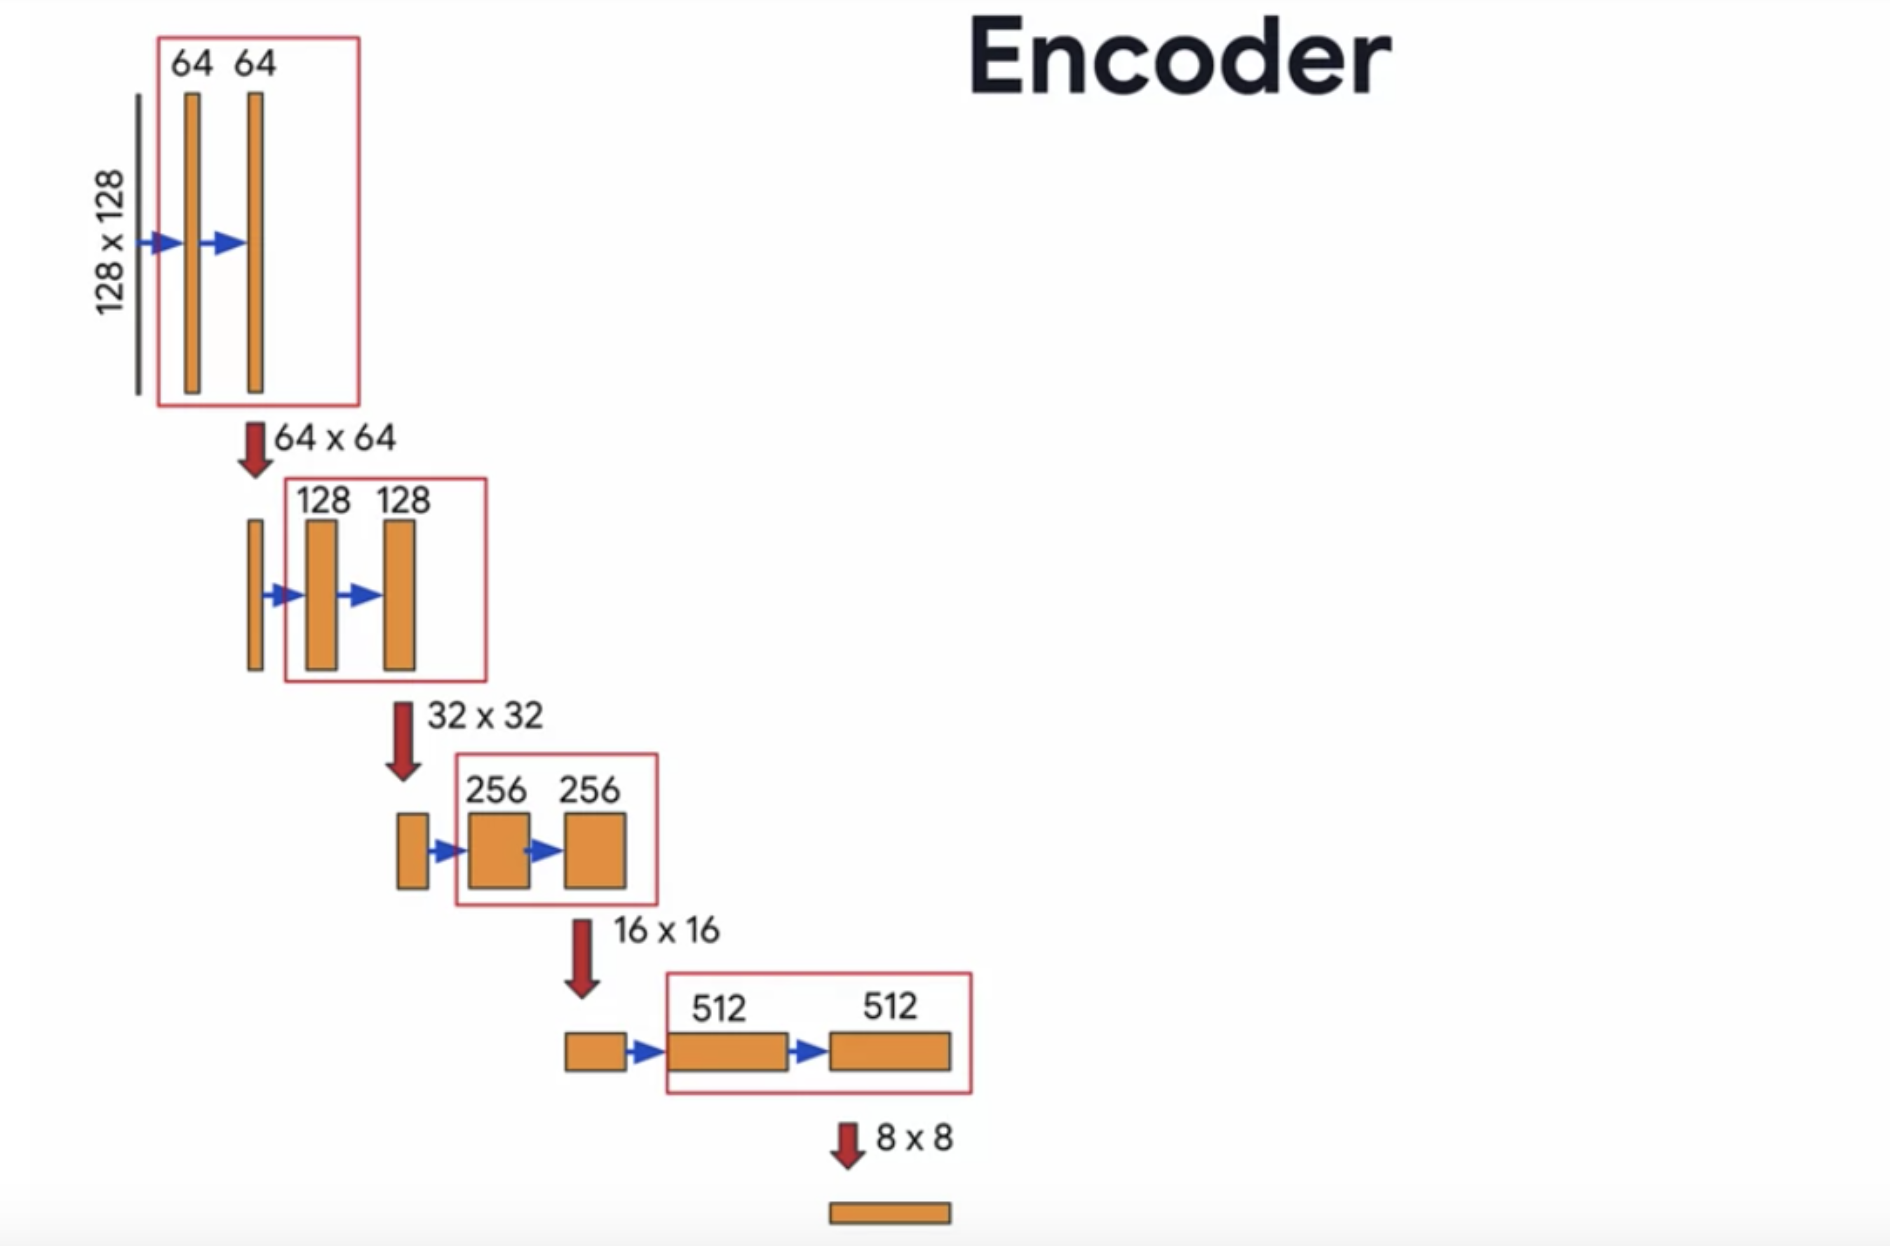<br>
The U-Net Encoder up close <br>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling.

The function will  return two tensors:
- `next_layer`: That will go into the next block.
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

In [7]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=32, dropout_prob=0, max_pooling=True):
        """
        Convolutional downsampling block

        Arguments:
            in_ch -- Number of channels of input tensor
            n_filters -- Number of filters for the convolutional layers
            dropout_prob -- Dropout probability
            max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
        """
        super().__init__()

        ######################################################
        ###################### TO DO #########################
        ######################################################
        self.layer = nn.Sequential(
            nn.Conv2d(in_ch, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
        )

        self.dropout = None

        if dropout_prob != 0:
            self.dropout = nn.Dropout(p=dropout_prob)

        self.maxpool = None

        if max_pooling:
            self.maxpool = nn.MaxPool2d(2)

        ######################################################
        ######################################################
        ######################################################

    def forward(self, x):
        """
        Convolutional downsampling forward

        Arguments:
            x -- Input data/batch
        Returns:
            next_layer, skip_connection --  Next layer and skip connection outputs
        """
        ######################################################
        ###################### TO DO #########################
        ######################################################
        skip_connection = self.layer(x)

        skip_connection = self.layer(x)

        if self.dropout is not None:
            skip_connection = self.dropout(skip_connection)

        next_layer = skip_connection.clone()

        if self.maxpool is not None:
            next_layer = self.maxpool(next_layer)
        ######################################################
        ######################################################
        ######################################################

        return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

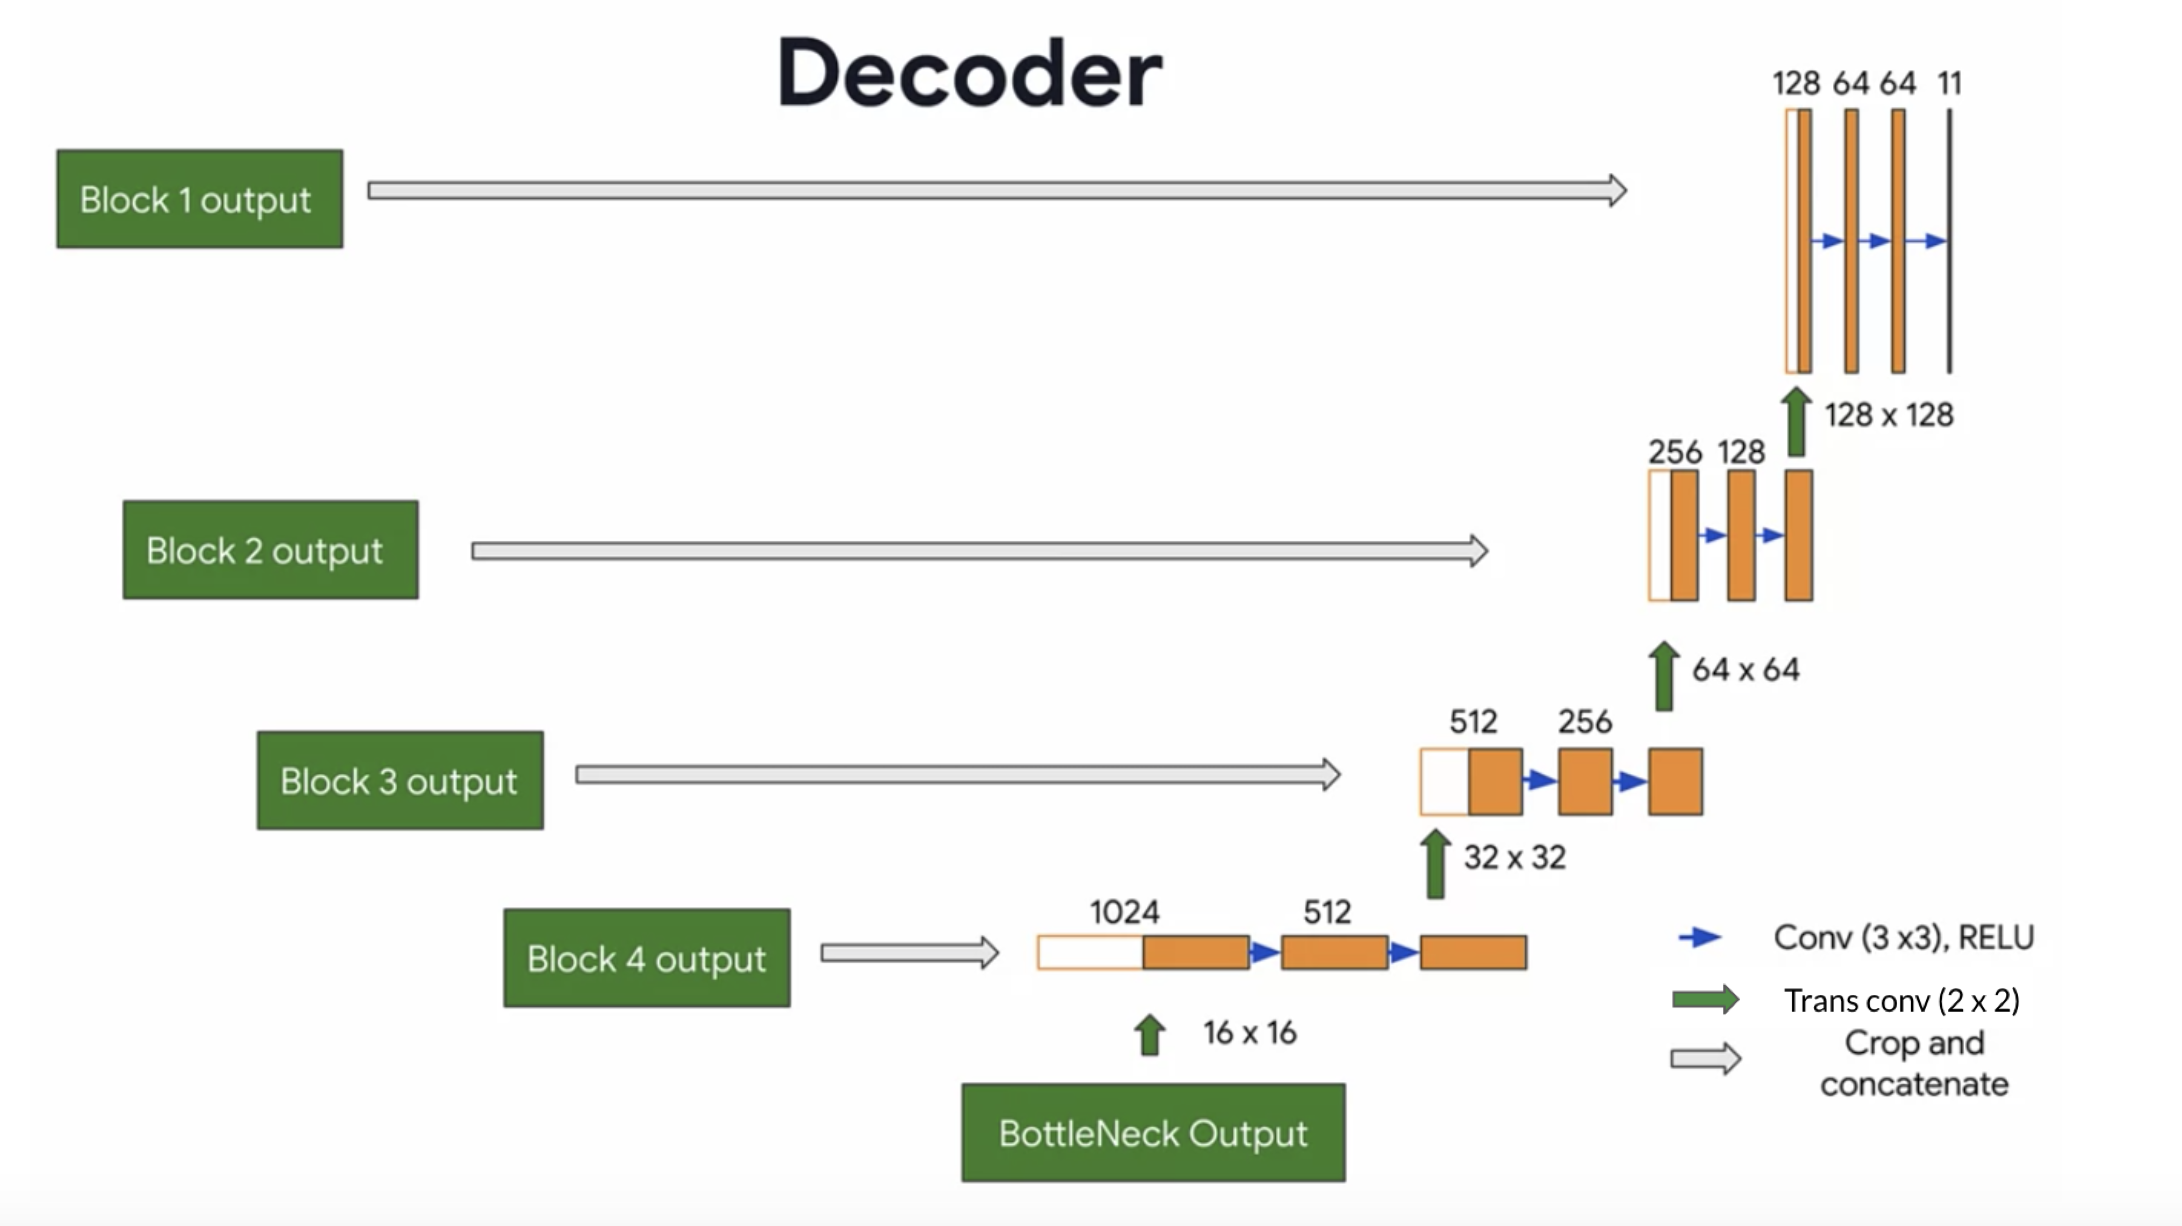<br>
The U-Net Decoder up close <br>

There are two new components in the decoder: `up` and `cat`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder.

Here you'll encounter the `ConvTranspose2d` layer, which performs the inverse of the `Conv2d` layer.



In [8]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=32):
        """
        Convolutional upsampling block

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            skip_ch -- Number of channels of input tensor from previous skip layer
            n_filters -- Number of filters for the convolutional layers
        """
        super().__init__()
        ######################################################
        ###################### TO DO #########################
        ######################################################
        self.convt = nn.ConvTranspose2d(in_ch, n_filters, kernel_size=2, stride=2)

        self.layer = nn.Sequential(
            nn.Conv2d(skip_ch + n_filters, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
        )

        ######################################################
        ######################################################
        ######################################################

    def forward(self, expansive_input, contractive_input):
        """
        Convolutional upsampling forward

        Arguments:
            expansive_input -- Data from bottleneck or previous upsampling_block
            contractive_input -- Data from corresponding layer in the encoder
        Returns:
            conv -- Tensor output
        """
        ######################################################
        ###################### TO DO #########################
        ######################################################
        out = self.convt(expansive_input)
        cat = torch.cat((contractive_input, out), 1)
        conv = self.layer(cat)
        ######################################################
        ######################################################
        ######################################################

        return conv

<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. **That's because there are 23 possible labels for each pixel in this self-driving car dataset.**

In [9]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=32, n_classes=23):
        """
        UNet

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            n_filters -- Number of filters for the convolutional layers
            n_classes -- Number of diffrent segments
        """
        super().__init__()
        # Down-sampling
        ######################################################
        ###################### TO DO #########################
        ######################################################
        self.down1 = conv_block(
            in_ch, n_filters=n_filters, dropout_prob=0, max_pooling=True
        )

        self.down2 = conv_block(
            n_filters, n_filters=n_filters * 2, dropout_prob=0, max_pooling=True
        )

        self.down3 = conv_block(
            n_filters * 2, n_filters=n_filters * 4, dropout_prob=0, max_pooling=True
        )

        self.down4 = conv_block(
            n_filters * 4, n_filters=n_filters * 8, dropout_prob=0.5, max_pooling=True
        )

        self.down5 = conv_block(
            n_filters * 8, n_filters=n_filters * 16, dropout_prob=0.5, max_pooling=False
        )
        ######################################################
        ######################################################
        ######################################################

        # Up-sampling
        ######################################################
        ###################### TO DO #########################
        ######################################################
        self.up1 = upsampling_block(
            n_filters * 16, n_filters * 8, n_filters=n_filters * 8
        )
        self.up2 = upsampling_block(
            n_filters * 8, n_filters * 4, n_filters=n_filters * 4
        )
        self.up3 = upsampling_block(
            n_filters * 4, n_filters * 2, n_filters=n_filters * 2
        )
        self.up4 = upsampling_block(n_filters * 2, n_filters, n_filters=n_filters)
        ######################################################
        ######################################################
        ######################################################
        self.last = nn.Sequential(
            nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_classes, kernel_size=1),
        )

    def forward(self, x):
        """
        UNet forward

        Arguments:
            x -- Input data/batch

        Returns:
            out -- Tensor output (Segmented image)
        """
        ######################################################
        ###################### TO DO #########################
        ######################################################
        next_layer1, skip_connection1 = self.down1(x)
        next_layer2, skip_connection2 = self.down2(next_layer1)
        next_layer3, skip_connection3 = self.down3(next_layer2)
        next_layer4, skip_connection4 = self.down4(next_layer3)
        next_layer5, skip_connection5 = self.down5(next_layer4)

        next_layer6 = self.up1(next_layer5, skip_connection4)
        next_layer7 = self.up2(next_layer6, skip_connection3)
        next_layer8 = self.up3(next_layer7, skip_connection2)
        next_layer9 = self.up4(next_layer8, skip_connection1)

        out = self.last(next_layer9)

        ######################################################
        ######################################################
        ######################################################

        return out

### Check out the model summary

In [10]:
unet = UNet().to(device)
# summary(unet, (3, 192, 256))

<a name='3-6'></a>
### 3.6 - Dataset Loader For training and test

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible.

In [7]:
from sklearn.model_selection import train_test_split

dataset = Segmentation_Dataset(image_path, mask_path)

train_dataset, test_dataset = train_test_split(dataset, test_size=0.20, random_state=42)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].permute(1, 2, 0))
        plt.axis('off')
    return plt

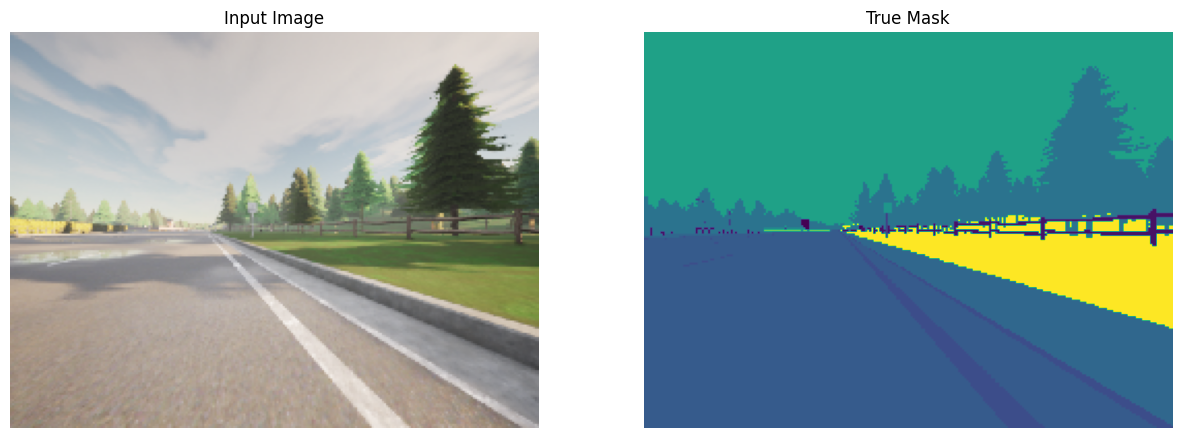

In [13]:
######################################################
###################### TO DO #########################
######################################################

# Show first image of first batch and its corresponding mask from the dataset

display_list = [dataset[0]['IMAGE'], dataset[0]['MASK']]
plt.figure(figsize=(15, 15))

title = ['Input Image', 'True Mask']

for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i].permute(1, 2, 0))
    plt.axis('off')

######################################################
######################################################
######################################################

<a name='3-7'></a>
### 3.7 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability.

We recommend using the cross entropy loss and the Adam optimizer.

In [14]:
criterion = nn.CrossEntropyLoss()

In [15]:
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, betas=(B1, B2))

<a name='4'></a>
## 4 - Train the Model

Implement the `train` function below to train the model.

In [21]:
losses = []
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(train_dataloader):

        ######################################################
        ###################### TO DO #########################
        ######################################################
        # Complete the train loop                            #
        # Hint: You might need to reshape MASK prior to      #
        #       calculating the loss using the code below:   #
        #       N, C, H, W = MASK.shape                      #
        #       MASK = MASK.reshape((N, H, W)).long()        #
        ######################################################
        ######################################################
        ######################################################
        x = batch["IMAGE"]
        y = batch["MASK"]

        x = x.to(device)
        y = y.to(device)

        N, C, H, W = y.shape
        y = y.reshape((N, H, W)).long()

        optimizer.zero_grad()

        out = unet(x)

        loss = criterion(out, y)

        epoch_losses.append(loss.item())

        loss.backward()

        optimizer.step()

        print(f"EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}")
    losses.append(np.mean(epoch_losses))

EPOCH#0,	 Batch#0,	 Loss:2.779249429702759
EPOCH#0,	 Batch#1,	 Loss:2.760467529296875
EPOCH#0,	 Batch#2,	 Loss:2.735459089279175
EPOCH#0,	 Batch#3,	 Loss:2.716817617416382
EPOCH#0,	 Batch#4,	 Loss:2.702885627746582
EPOCH#0,	 Batch#5,	 Loss:2.6761157512664795
EPOCH#0,	 Batch#6,	 Loss:2.6469078063964844
EPOCH#0,	 Batch#7,	 Loss:2.6266465187072754
EPOCH#0,	 Batch#8,	 Loss:2.635877847671509
EPOCH#0,	 Batch#9,	 Loss:2.607272148132324
EPOCH#0,	 Batch#10,	 Loss:2.57157826423645
EPOCH#0,	 Batch#11,	 Loss:2.569532871246338
EPOCH#0,	 Batch#12,	 Loss:2.5365042686462402
EPOCH#0,	 Batch#13,	 Loss:2.5334665775299072
EPOCH#0,	 Batch#14,	 Loss:2.4973642826080322
EPOCH#0,	 Batch#15,	 Loss:2.465670585632324
EPOCH#0,	 Batch#16,	 Loss:2.4671082496643066
EPOCH#0,	 Batch#17,	 Loss:2.4313957691192627
EPOCH#0,	 Batch#18,	 Loss:2.4146223068237305
EPOCH#0,	 Batch#19,	 Loss:2.3717048168182373
EPOCH#0,	 Batch#20,	 Loss:2.3762505054473877
EPOCH#0,	 Batch#21,	 Loss:2.3479995727539062
EPOCH#0,	 Batch#22,	 Loss:2.346

<a name='4-1'></a>
### 4.1 - Create Predicted Masks

Now, define a function that uses `torch.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

_(The Predicted class of each pixel is the argmax of different probs assigned to that pixel)_

In [9]:
def create_mask(pred_mask):
    ######################################################
    ###################### TO DO #########################
    ######################################################
    pred_mask = pred_mask.argmax(dim=1, keepdim=True)
    ######################################################
    ######################################################
    ######################################################

    return pred_mask

<a name='4-2'></a>
### 4.2 - Plot Loss Function

Plot the loss function value of your model in different iterations.

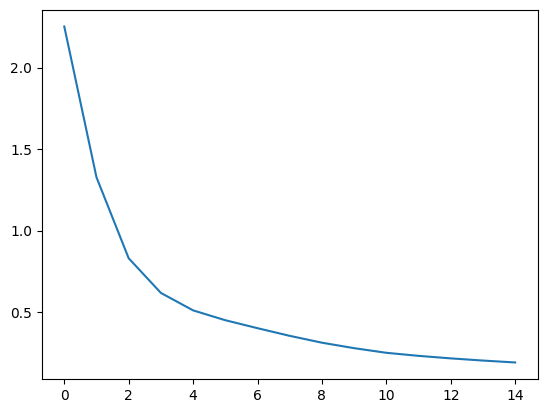

In [23]:
plt.plot(np.arange(len(losses)), losses)

<a name='4-3'></a>
### 4.3 - mIoU

calculate mIoU for test dataset images and report average mIoU for all the images.

- we have 23 classes in our dataset

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_miou(y_true, y_pred, num_classes):
    conf_mat = np.zeros((num_classes, num_classes))

    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    conf_mat += confusion_matrix(y_true_flat, y_pred_flat, labels=range(num_classes))

    IoU = []
    for i in range(num_classes):
        intersection = conf_mat[i, i]
        union = np.sum(conf_mat[i, :]) + np.sum(conf_mat[:, i]) - intersection
        if union == 0:
            IoU.append(float('nan'))
        else:
            IoU.append(intersection / union)

    IoU = [iou for iou in IoU if not np.isnan(iou)]

    miou = np.mean(IoU)
    return miou

In [25]:
num_classes = 23
mious = []
for i, batch in enumerate(test_dataloader):
  with torch.no_grad():
    image = batch
    y_pred = unet(image["IMAGE"].to(torch.float32).to(device))
    _, y_pred = torch.max(y_pred, 1, keepdim=True)

    y_true = np.array(image["MASK"])
    y_pred = (y_pred.cpu().detach().numpy())

    miou = calculate_miou(y_true, y_pred, num_classes)
    mious.append(miou)

print(f"average miou for test dataset: {sum(mious) / len(mious)}")


average miou for test dataset: 0.34915215255320753


<a name='4-3'></a>
### 4.5 - Show Predictions

Now, let's see your predictions (masks) vs ground truth masks to understand how well your model did.

In [11]:
def show_predictions(dataloader, device, num=1):
    """
    Displays the first image of each of the num batches
    """
    unet.eval()
    with torch.no_grad():
      for i, batch in enumerate(dataloader):
          IMG = batch["IMAGE"].to(device)
          MASK = batch["MASK"].to(device)

          pred_mask = create_mask(unet(IMG))[0]
          display([IMG[0].cpu(), MASK[0].cpu(), pred_mask.cpu()]).show()

          if i >= num:
              break

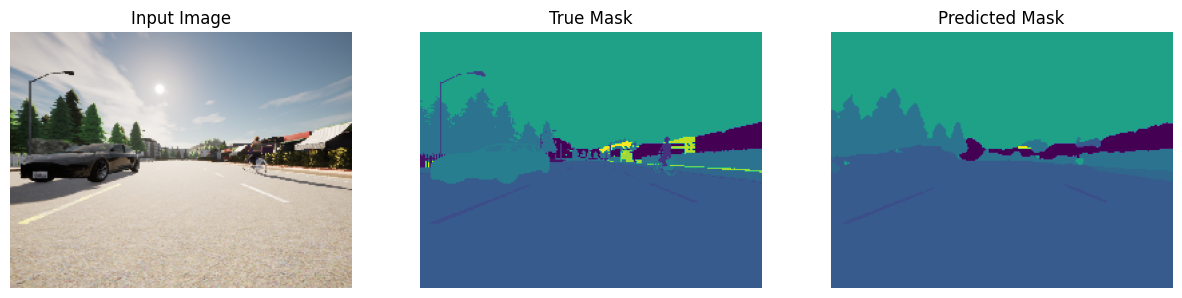

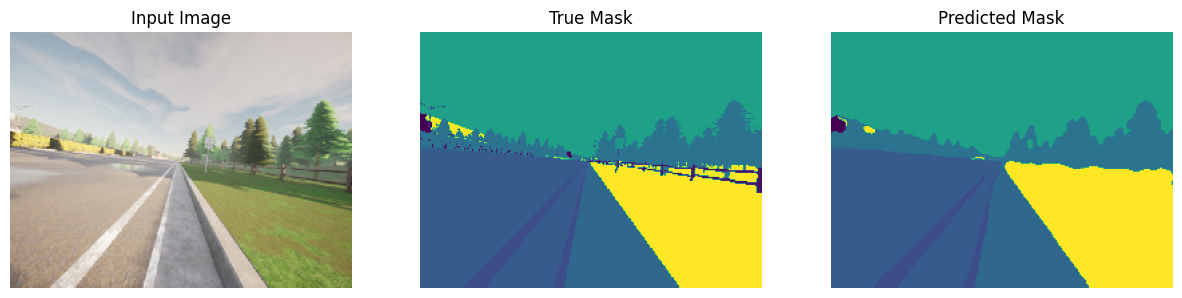

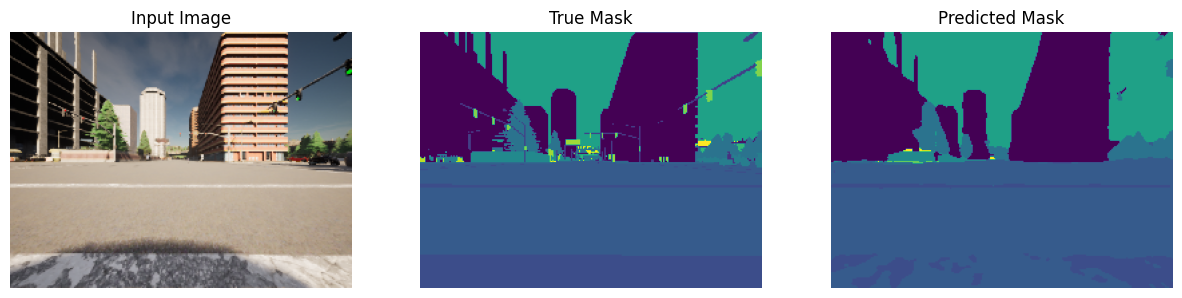

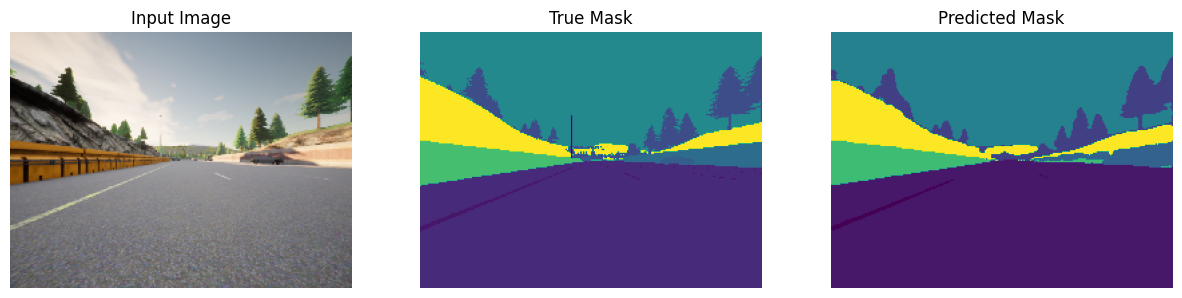

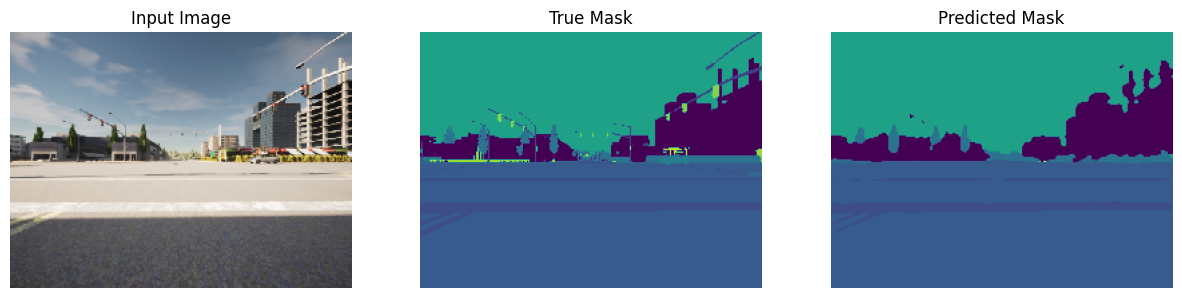

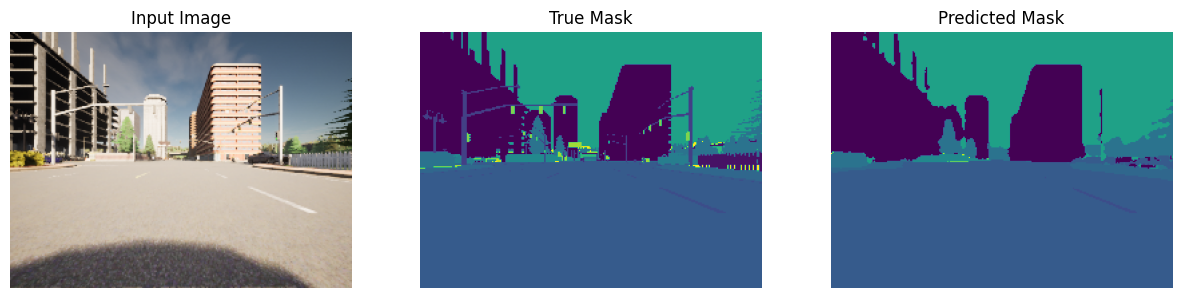

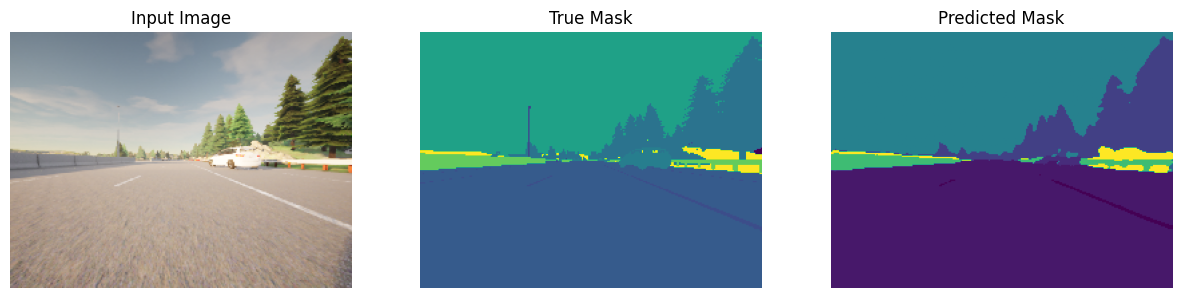

In [27]:
show_predictions(test_dataloader, device, 6)

## 5. Making the architecture better?!

Here, we want to try to make the UNet's model architecture, better. We try an approach named __Attention UNet__. This architecture tries to focus on the important parts of the image, and ignore the rest. Using this idea, we try to make the features (in `upsampling` steps) better, to finally reach a better __Decoder__ and thus, better predictions.

## 5.1 - Attention UNet

Here, is an overview of general architecture of Attention UNet:

<img src="./Images/1.png" style="width:100%;height:auto;">

As you can see, the architecture is similar to the UNet, but with the addition of Attention Gates. These gates are used to focus on the important parts of the image, and ignore the rest. But, what are these attention gates, precisely?!

<img src="./Images/2.png" style="width:100%;height:auto;">

As you can see, the attention gate is a simple architecture, which uses the features from the encoder, and the features from the decoder, adds them and also uses residual connections to output $\hat{x_l}$. Please note that $W_x \in \mathbb{R}^{F_l \times F_{int}}$, $W_g \in \mathbb{R}^{F_g \times F_{int}}$ and $\Psi \in \mathbb{R}^{F_{int} \times 1}$ are linear transformations which are being computed using channel-wise $1 \times 1 \times 1$ convolutions for the input tensors. In other contexts, this is called _vector concatenation-based attention_, where the concatenated features $x^l$ and $g$ are linearly mapped into a $\mathbb{R}^F_{int}$ dimensional _intermediate_ space.

Let's design the `AttentionBlock` class, which will be used in the `AttentionUNet` model:

In [12]:
class AttentionBlock(nn.Module):
    def __init__(self, F_l, F_int, F_g):
        super(AttentionBlock, self).__init__()
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int),
        )
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int),
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        x1 = self.W_x(x)
        g1 = self.W_g(g)
        psi = self.relu(x1 + g1)
        psi = self.psi(psi)
        return x * psi

In [13]:
class new_conv_block(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_prob=0):
        super(new_conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.dropout = None
        if dropout_prob != 0:
            self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.conv(x)
        if self.dropout is not None:
            x = self.dropout(x)
        return x

In [14]:
class new_upsample_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(new_upsample_block, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [15]:
class UNet_With_Attention(nn.Module):
    def __init__(self, in_ch=3, out_channel=23):
        """
        UNet

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            out_channel -- Number of channels of output tensor
        """
        super().__init__()
        # Down-sampling
        ######################################################
        ###################### TO DO #########################
        ######################################################
        self.down1 = new_conv_block(in_ch, 64)

        self.down2 = new_conv_block(64, 128)

        self.down3 = new_conv_block(128, 256)

        self.down4 = new_conv_block(256, 512)

        self.down5 = new_conv_block(512, 1024)

        ######################################################
        ######################################################
        ######################################################

        # Up-sampling
        ######################################################
        ###################### TO DO #########################
        ######################################################
        self.up1 = new_upsample_block(1024, 512)
        self.att1 = AttentionBlock(F_l=512, F_int=256, F_g=512)
        self.up_conv_block1 = new_conv_block(1024, 512)
        self.up2 = new_upsample_block(512, 256)
        self.att2 = AttentionBlock(F_l=256, F_int=128, F_g=256)
        self.up_conv_block2 = new_conv_block(512, 256)
        self.up3 = new_upsample_block(256, 128)
        self.att3 = AttentionBlock(F_l=128, F_int=64, F_g=128)
        self.up_conv_block3 = new_conv_block(256, 128)
        self.up4 = new_upsample_block(128, 64)
        self.att4 = AttentionBlock(F_l=64, F_int=32, F_g=64)
        self.up_conv_block4 = new_conv_block(128, 64)

        ######################################################
        ######################################################
        ######################################################
        self.last = nn.Sequential(
            nn.Conv2d(64, out_channel, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel_size=1, stride=1, padding=0),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        """
        UNet forward

        Arguments:
            x -- Input data/batch

        Returns:
            out -- Tensor output (Segmented image)
        """
        ######################################################
        ###################### TO DO #########################
        ######################################################
        x1 = self.down1(x)

        x2 = self.maxpool(x1)
        x2 = self.down2(x2)

        x3 = self.maxpool(x2)
        x3 = self.down3(x3)

        x4 = self.maxpool(x3)
        x4 = self.down4(x4)

        x5 = self.maxpool(x4)
        x5 = self.down5(x5)

        d5 = self.up1(x5)
        x4 = self.att1(x=x4, g=d5)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.up_conv_block1(d5)

        d4 = self.up2(d5)
        x3 = self.att2(x=x3, g=d4)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.up_conv_block2(d4)

        d3 = self.up3(d4)
        x2 = self.att3(x=x2, g=d3)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.up_conv_block3(d3)

        d2 = self.up4(d3)
        x1 = self.att4(x=x1, g=d2)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.up_conv_block4(d2)

        out = self.last(d2)

        ######################################################
        ######################################################
        ######################################################

        return out

In [16]:
unet = UNet_With_Attention().to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, betas=(B1, B2))
criterion = nn.CrossEntropyLoss()

In [17]:
losses = []
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(train_dataloader):

        ######################################################
        ###################### TO DO #########################
        ######################################################
        # Complete the train loop                            #
        # Hint: You might need to reshape MASK prior to      #
        #       calculating the loss using the code below:   #
        #       N, C, H, W = MASK.shape                      #
        #       MASK = MASK.reshape((N, H, W)).long()        #
        ######################################################
        ######################################################
        ######################################################
        x = batch["IMAGE"]
        y = batch["MASK"]
        x = x.to(device)
        y = y.to(device)

        N, C, H, W = y.shape
        y = y.reshape((N, H, W)).long()

        optimizer.zero_grad()

        out = unet(x)
        loss = criterion(out, y)

        epoch_losses.append(loss.item())

        loss.backward()

        optimizer.step()

        print(f"EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}")
    losses.append(np.mean(epoch_losses))

EPOCH#0,	 Batch#0,	 Loss:3.148573875427246
EPOCH#0,	 Batch#1,	 Loss:3.050767660140991
EPOCH#0,	 Batch#2,	 Loss:2.9990122318267822
EPOCH#0,	 Batch#3,	 Loss:2.8707122802734375
EPOCH#0,	 Batch#4,	 Loss:2.807326078414917
EPOCH#0,	 Batch#5,	 Loss:2.7396132946014404
EPOCH#0,	 Batch#6,	 Loss:2.6938278675079346
EPOCH#0,	 Batch#7,	 Loss:2.655259132385254
EPOCH#0,	 Batch#8,	 Loss:2.5999104976654053
EPOCH#0,	 Batch#9,	 Loss:2.543850898742676
EPOCH#0,	 Batch#10,	 Loss:2.524489402770996
EPOCH#0,	 Batch#11,	 Loss:2.4832849502563477
EPOCH#0,	 Batch#12,	 Loss:2.4511635303497314
EPOCH#0,	 Batch#13,	 Loss:2.4121885299682617
EPOCH#0,	 Batch#14,	 Loss:2.4315130710601807
EPOCH#0,	 Batch#15,	 Loss:2.336266279220581
EPOCH#0,	 Batch#16,	 Loss:2.2866451740264893
EPOCH#0,	 Batch#17,	 Loss:2.264648675918579
EPOCH#0,	 Batch#18,	 Loss:2.231945753097534
EPOCH#0,	 Batch#19,	 Loss:2.19625186920166
EPOCH#0,	 Batch#20,	 Loss:2.1732866764068604
EPOCH#0,	 Batch#21,	 Loss:2.1089670658111572
EPOCH#0,	 Batch#22,	 Loss:2.059

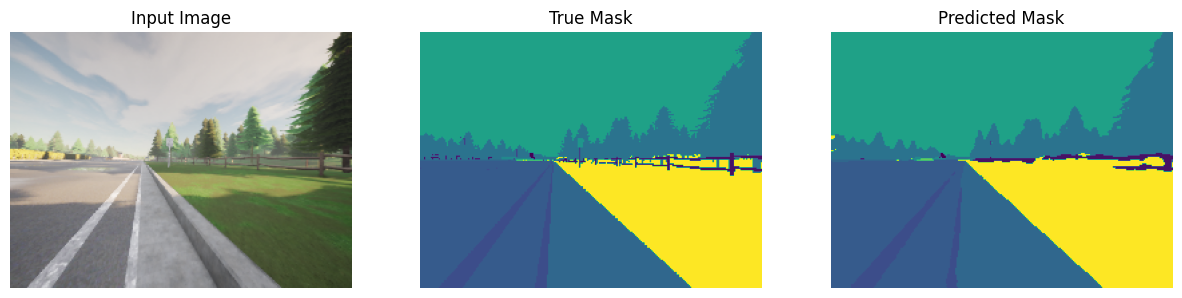

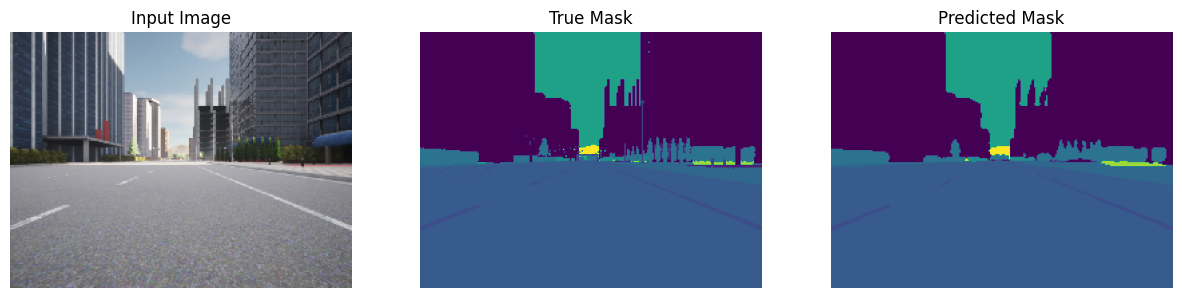

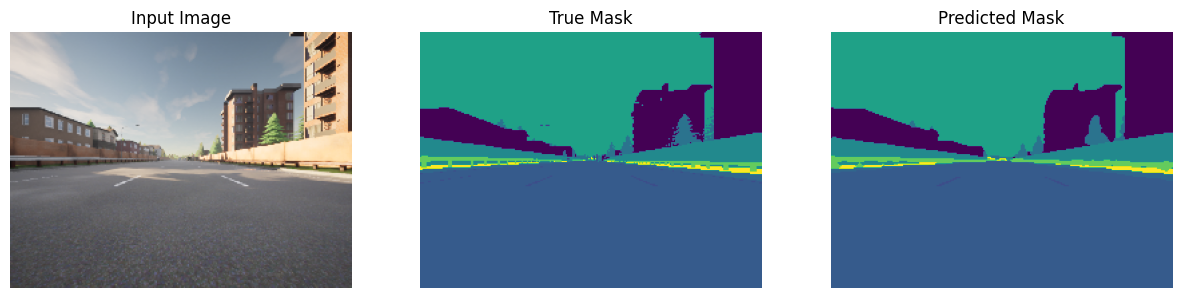

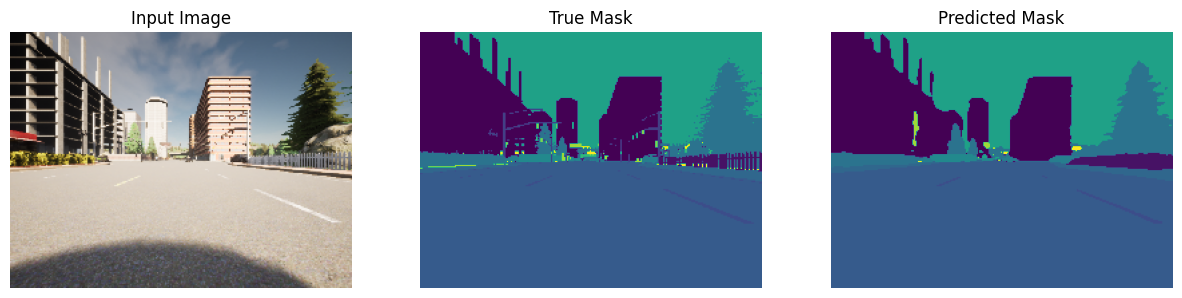

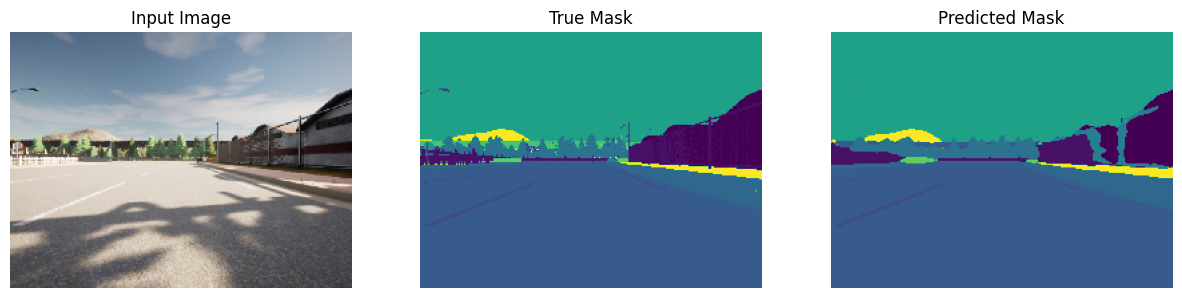

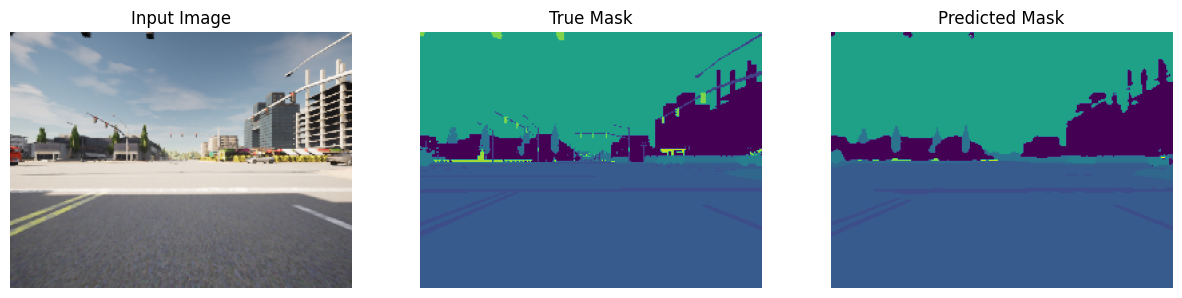

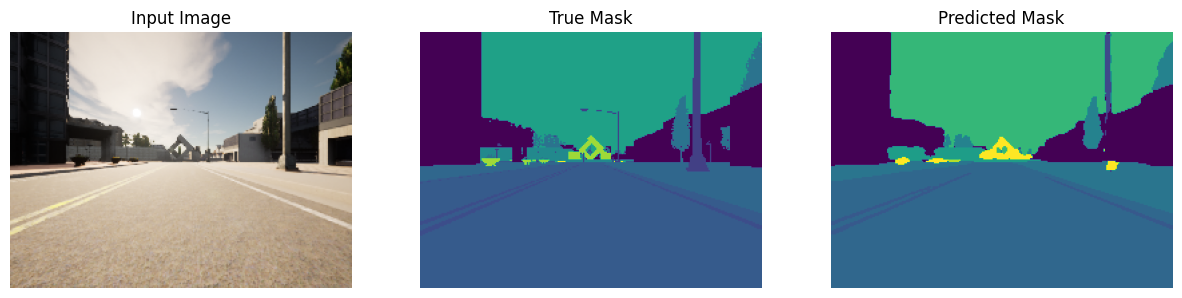

In [18]:
show_predictions(test_dataloader, device, 6)

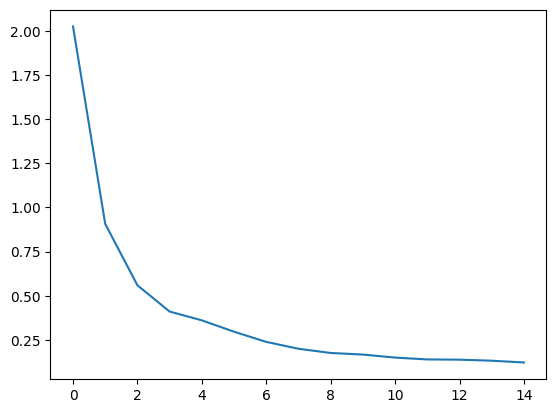

In [19]:
plt.plot(np.arange(len(losses)), losses)

<a name='5-2'></a>
### 5.2 - mIoU

calculate mIoU for test dataset images with new model using the defined function above and report average mIoU for all the images.

In [20]:
num_classes = 23
mious = []
for i, batch in enumerate(test_dataloader):
  with torch.no_grad():
    image = batch
    y_pred = unet(image["IMAGE"].to(torch.float32).to(device))
    _, y_pred = torch.max(y_pred, 1, keepdim=True)

    y_true = np.array(image["MASK"])
    y_pred = (y_pred.cpu().detach().numpy())

    miou = calculate_miou(y_true, y_pred, num_classes)
    mious.append(miou)

print(f"average miou for test dataset: {sum(mious) / len(mious)}")

average miou for test dataset: 0.47421665161114585
